In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train_df_raw, val_df_raw = train_test_split(df, test_size=0.2, random_state=42)

def get_safe_survival_mapping(train_data, val_data):
    train_fs = train_data.copy()
    val_fs = val_data.copy()
    train_fs['Surname'] = train_fs['Name'].apply(lambda x: x.split(',')[0])
    val_fs['Surname'] = val_fs['Name'].apply(lambda x: x.split(',')[0])
    
    train_fs['Family_Survival'] = 0.5
    val_fs['Family_Survival'] = 0.5

    for _, grp_df in train_fs.groupby(['Surname', 'Fare']):
        if len(grp_df) > 1:
            for ind, row in grp_df.iterrows():
                others = grp_df.drop(ind)
                if others['Survived'].max() == 1.0: train_fs.loc[ind, 'Family_Survival'] = 1
                elif others['Survived'].max() == 0.0: train_fs.loc[ind, 'Family_Survival'] = 0

    for _, grp_df in train_fs.groupby('Ticket'):
        if len(grp_df) > 1:
            for ind, row in grp_df.iterrows():
                if train_fs.loc[ind, 'Family_Survival'] == 0.5:
                    others = grp_df.drop(ind)
                    if others['Survived'].max() == 1.0: train_fs.loc[ind, 'Family_Survival'] = 1
                    elif others['Survived'].max() == 0.0: train_fs.loc[ind, 'Family_Survival'] = 0

    for ind, row in val_fs.iterrows():
        family_in_train = train_fs[(train_fs['Surname'] == row['Surname']) & (train_fs['Fare'] == row['Fare'])]
        ticket_in_train = train_fs[train_fs['Ticket'] == row['Ticket']]
        
        combined = pd.concat([family_in_train, ticket_in_train])
        
        if len(combined) > 0:
            if combined['Survived'].max() == 1.0:
                val_fs.loc[ind, 'Family_Survival'] = 1
            elif combined['Survived'].max() == 0.0:
                val_fs.loc[ind, 'Family_Survival'] = 0
                
    full_mapping = pd.concat([train_fs[['PassengerId', 'Family_Survival']], 
                             val_fs[['PassengerId', 'Family_Survival']]])
    return full_mapping

def prepare_data(df_input, survival_mapping):
    df = df_input.copy()
    
    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    df = df.merge(survival_mapping, on='PassengerId', how='left')
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Service')
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Lady', 'Countess', 'Dona'], 'Noble')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Officer')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'Top')
    df['Deck'] = df['Deck'].replace(['D', 'E'], 'Middle')
    df['Deck'] = df['Deck'].replace(['F', 'G', 'T', 'M'], 'Low')
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    df = pd.get_dummies(df, columns=['Title', 'Deck', 'Embarked'])
    
    return df.astype(float)

fs_map = get_safe_survival_mapping(train_df_raw, val_df_raw)

X_train = prepare_data(train_df_raw, fs_map).drop(columns=['Survived'])
y_train = train_df_raw['Survived']

X_val = prepare_data(val_df_raw, fs_map).drop(columns=['Survived'])
y_val = val_df_raw['Survived']

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 15),
        'random_state': 42
    }
    model = RandomForestClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=5).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

final_model = RandomForestClassifier(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)

print("-" * 30)
print(f"Лучший CV результат: {study.best_value:.2%}")
print(f"Честная точность на валидации: {final_model.score(X_val, y_val):.2%}")
print("best_params = {")
for key, value in study.best_params.items():
    if isinstance(value, str):
        print(f"    '{key}': '{value}',")
    else:
        print(f"    '{key}': {value},")
print("    'random_state': 42")
print("}") 
print("-" * 30)

d:\system\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-29 10:34:06,828] A new study created in memory with name: no-name-7de4d964-fcfc-4eaf-8d62-404c9cd9a25f
[I 2025-12-29 10:34:11,102] Trial 0 finished with value: 0.8412390426474934 and parameters: {'n_estimators': 316, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8412390426474934.
[I 2025-12-29 10:34:14,960] Trial 1 finished with value: 0.8300009849305624 and parameters: {'n_estimators': 303, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8412390426474934.
[I 2025-12-29 10:34:21,043] Trial 2 finished with value: 0.8356150891362158 and parameters: {'n_estimators': 450, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 11}. Best is tr

------------------------------
Лучший CV результат: 84.69%
Честная точность на валидации: 83.80%
best_params = {
    'n_estimators': 370,
    'max_depth': 6,
    'min_samples_split': 13,
    'min_samples_leaf': 4,
    'random_state': 42
}
------------------------------


Title_Noble           0.000000
Title_the Countess    0.000000
Title_Officer         0.000387
Embarked_Q            0.003124
Title_Service         0.004125
Deck_Top              0.006575
Title_Master          0.007049
Embarked_S            0.008498
Embarked_C            0.008567
Deck_Middle           0.010505
Has_Cabin             0.030980
Deck_Low              0.035343
Ticket_Group_Size     0.038038
FamilySize            0.039808
Age                   0.045718
Title_Miss            0.053409
Pclass                0.067755
Fare                  0.071562
Title_Mrs             0.078833
Family_Survival       0.093780
Title_Mr              0.197343
Sex                   0.198600
dtype: float64


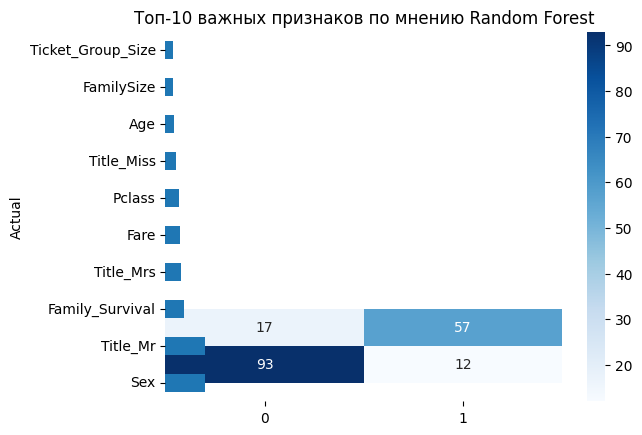

Средний возраст в ошибках: 29.244285714285713
Распределение по классам в ошибках:
 Pclass
3.0    85
1.0    47
2.0    29
Name: count, dtype: int64


Text(50.722222222222214, 0.5, 'Actual')

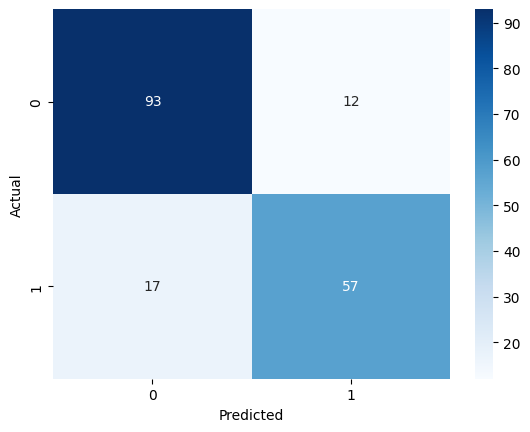

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_val, final_model.predict(X_val)), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=True).head(40))
importances.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков по мнению Random Forest')
plt.show()

errors_df = X_val.copy()
errors_df['Actual'] = y_val
errors_df['Predicted'] = final_model.predict(X_val)
errors = errors_df[errors_df['Actual'] != errors_df['Predicted']]
errors.head(10)
print("Средний возраст в ошибках:", errors['Age'].mean())
print("Распределение по классам в ошибках:\n", errors['Pclass'].value_counts())

y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(50.722222222222214, 0.5, 'Actual')

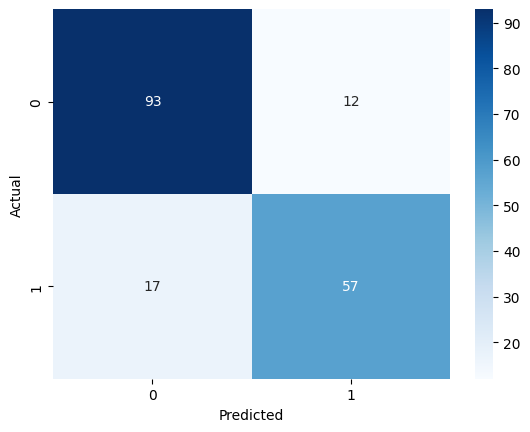

In [3]:
y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')